# Исследование сервиса аренды самокатов GoFast

Требуется проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Имеются данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки Free
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;


- с подпиской Ultra

    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
Проведем исследования относительно того, насколько интересна возможность иметь подписку как с точки зрения бизнеса, так и с точки зрения пользователя. Для этого предварительно выполним предобработку данных и подготовим таблицы, позволяющие рассмотреть отдельно группу пользователей с подпиской и без.  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [5]:
#users = pd.read_csv('/datasets/users_go.csv')

try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    
users.to_csv('users_go.csv', index=False)

display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
#rides = pd.read_csv('/datasets/rides_go.csv')

try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

rides.to_csv('rides_go.csv', index=False) 
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
#subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

subscriptions.to_csv('subscriptions_go.csv', index=False) 
display(subscriptions.head())
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
date_min = min(rides['date'])
date_max = max(rides['date'])
print(f'Данные за период с {date_min} по {date_max} ')

Данные за период с 2021-01-01 по 2021-12-30 


Согласно документации к данным:

**users** (информация о пользователях)
- `user_id` — уникальный идентификатор пользователя;           
- `name` — имя пользователя;  
- `age` — возраст;  
- `city` — город;
- `subscription_type` — тип подписки (free, ultra).


**rides** (информация о поездках)
- `user_id` — уникальный идентификатор пользователя;           
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах);  
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;  
- `date` — дата совершения поездки.

**subscriptions** (информация о подписках)
- `subscription_type` — тип подписки (free, ultra);
- `minute_price` — стоимость одной минуты поездки по данной подписке;
- `start_ride_price` — стоимость начала поездки;
- `subscription_fee` — стоимость ежемесячного платежа.

**Вывод**

Имеются три взаимосвязанные таблицы: **users** (5 столбцов), **rides** (4 столбца), **subscription** (4 столбца). Названия столбцов соответствуют хорошему стилю.
В каждой строке таблиц — данные о пользователях, их поездках и информация по подписке. Данные о поездках приведены за 2021 календарный год.

#### Шаг 2. Предобработка данных

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d') # Приводим к типу даты дату поездки
rides['month'] = rides['date'].dt.month # Добавляем столбец с месяцем поездки
rides.info() # Проверяем внесенные изменения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [10]:
# Проверяем наличие явных дубликатов в датафреймах
users.duplicated().sum()

31

In [11]:
subscriptions.duplicated().sum()

0

In [12]:
rides.duplicated().sum()


0

In [13]:
# Удаляем явные дубликаты
users = users.drop_duplicates()

In [14]:
# Проверяем наличие пропущенных значений в датафреймах
users.isna().sum()


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
rides.isna().sum()


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [16]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [17]:
# Проверяем наличие неявных дубликатов
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

**Вывод**

- Приведена к типу даты дата поездки.

- Добавлен столбец `month` с месяцем поездки.

- В таблице **users** есть явные дубликаты, удалили их.

- Пропущенных значений в таблицах нет.

- Неявных дубликатов не обнаружено.

#### Шаг 3. Исследовательский анализ данных

Text(0.5, 0, 'Количество')

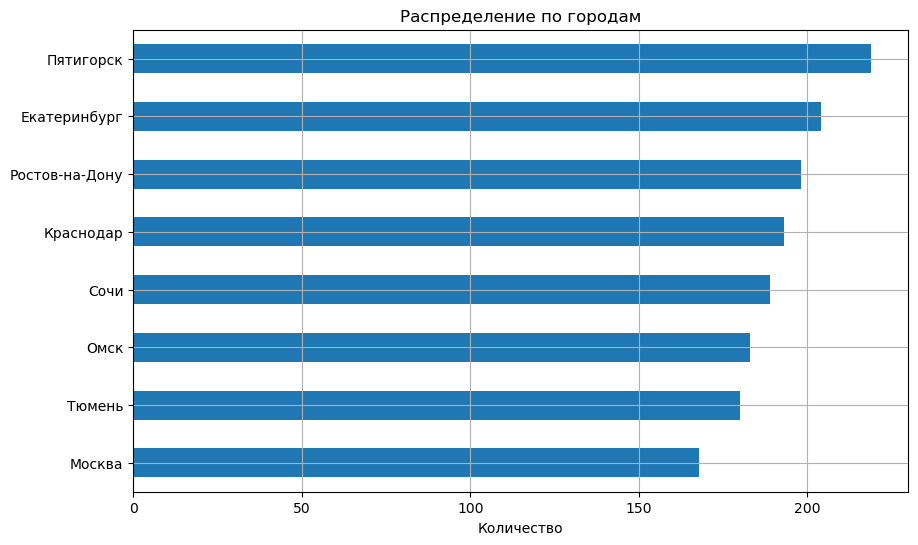

In [18]:
# Частота встречаемости городов
users['city'].value_counts(ascending=True).plot(y='city', kind='barh', grid=True, figsize=(10,6))
plt.title('Распределение по городам')
plt.xlabel('Количество')

В данных представлено 8 городов, в которых число пользователей распределено почти одинаково. Больше всех пользователей сервиса GoFast оказалось в Пятигорске (около 220), меньше всего - в Москве (около 170). Скорее всего, это связано с уровнем конкуренции сервисов в конкретном регионе. Сам парк самокатов больше всего в Москве, но здесь и выше уровень конкуренции. В Пятигорске же работает мало компаний, предоставляющих аренду самокатов.

In [19]:
# Распределение по подпискам
users_sub = users['subscription_type'].value_counts()
print(users_sub)

free     835
ultra    699
Name: subscription_type, dtype: int64


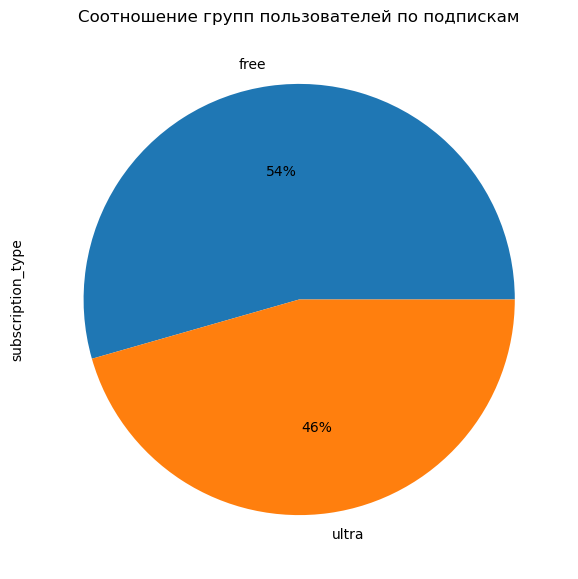

In [20]:
users_sub.plot(kind = 'pie', y = users_sub, autopct = '%1.0f%%', figsize=(7,7),
    title = 'Соотношение групп пользователей по подпискам');

Хорошо представлены пользователи и с подпиской (ultra), и без подписки (free). Пользователей, имеющих платную подписку немного больше (835 человек против 699 человек без подписки).

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


Text(0, 0.5, 'Количество')

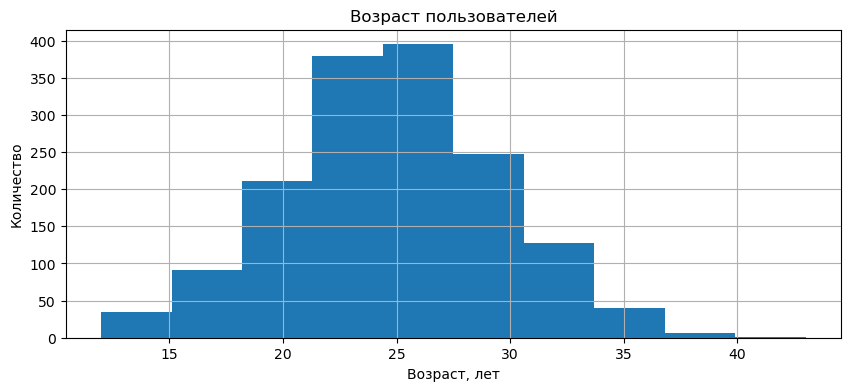

In [21]:
# Возраст пользователей
print(users['age'].describe())
users['age'].hist(bins=10, grid=True, figsize=(10,4))
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')

Возраст пользователей находится в пределах от 12 до 43 лет. Возраст большинства приходится на 20 - 30 лет. При этом среднее и медианное значения возраста совпадают (около 25 лет). Это значит, что данные не содержат выбросов или слишком необычных значений.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

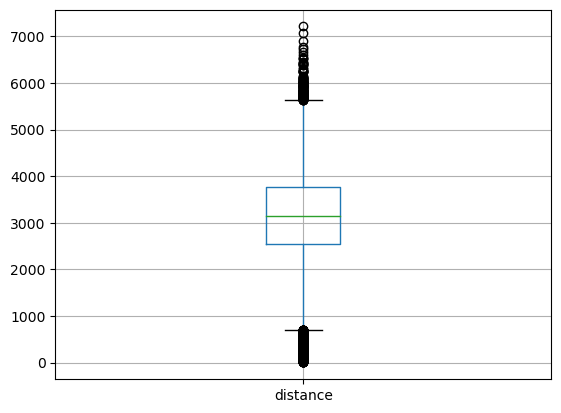

In [22]:
# Расстояние, которое пользователь преодолел за одну поездку
rides.boxplot('distance')
rides['distance'].describe()

Text(0, 0.5, 'Количество поездок')

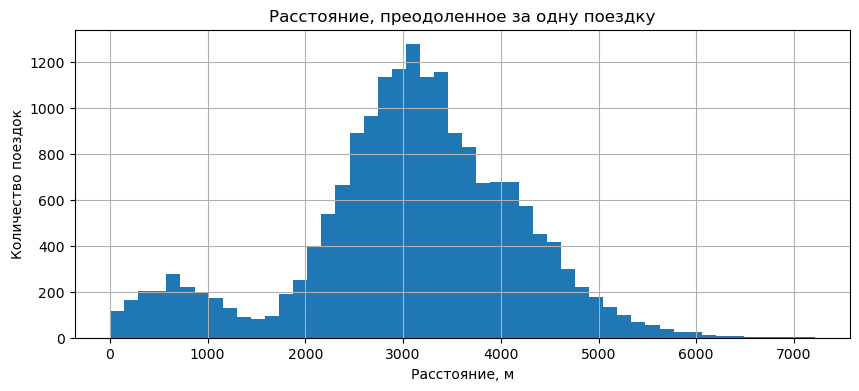

In [23]:
rides['distance'].hist(bins=50, grid=True, figsize=(10,4))
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

Длина одной поездки составляет в основном 2543-3777 м (медианное значение - 3133 м).

В построенной диаграмме размаха видно, что верхний "ус" упирается в 5600 м (=1,5 межквартального размаха + 3-й квартиль), что считается границей нормального размаха. Все, что более 5600 м, можно отнести к выбросам, то есть к необычно длинным дистанциям.
И наоборот, необычно короткие дистанции - те, что меньше 693 м.

Необычно короткие дистанции с пиковым значением около 700 м связаны с тем, что пользователь пробует ехать на самокате, но в результате отказывается от этой идеи. Возможно, этот пользователь впервые пробует ехать на самокате и понимает, что данный вид транспорта ему не подходит (некомфортно, не получается, изменились обстоятельства итп). Вторая причина может быть связана с неисправностью самоката.  

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

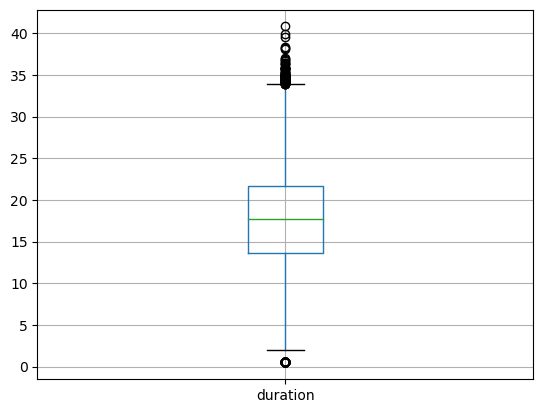

In [24]:
# Продолжительность поездок
rides.boxplot('duration')
rides['duration'].describe()

Text(0, 0.5, 'Количество поездок')

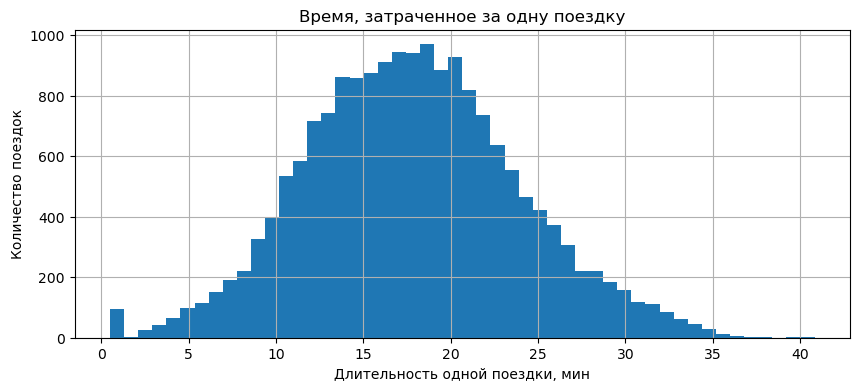

In [25]:
rides['duration'].hist(bins=50, grid=True, figsize=(10,4))
plt.title('Время, затраченное за одну поездку')
plt.xlabel('Длительность одной поездки, мин')
plt.ylabel('Количество поездок')

Длительность одной поездки представляет собой нормальное распределение и составляет в основном 13-21 мин (медианное значение - 17 мин).

В построенной диаграмме размаха видно, что верхний "ус" упирается в 34 мин (=1,5 межквартального размаха + 3-й квартиль), что считается границей нормального размаха. Все, что более 34 мин, можно отнести к выбросам, то есть к необычно долгим поездкам.

Необычный пик около 0 может говорить об ошибках в данных, поэтому рассмотрим подробнее данные строки.

In [26]:
print(rides.loc[rides['duration'] < 1].describe())
rides.loc[rides['duration'] < 1]

           user_id     distance  duration      month
count    95.000000    95.000000      95.0  95.000000
mean   1092.210526  5113.176549       0.5   6.484211
std     244.028551   658.254104       0.0   3.709858
min     701.000000  4030.308008       0.5   1.000000
25%     901.000000  4611.510820       0.5   3.000000
50%    1069.000000  5052.769411       0.5   6.000000
75%    1310.500000  5488.459099       0.5  10.000000
max    1524.000000  7211.007745       0.5  12.000000


,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Оказывается, в 95 строках указана длительность каждой поездки 0,5 минут. При этом длина таких поездок находится в пределах 4030-7211 м. Вполне может быть, что в этом случае имелось ввиду 0,5 часа (т.е. 30 минут). Такое соотношение времени и длины поездки больше похоже на реальность. 
Так как количество в 95 строк ничтожно мало, просто удалим эти строки. И еще раз посмотрим на распределение по времени.

Text(0, 0.5, 'Количество поездок')

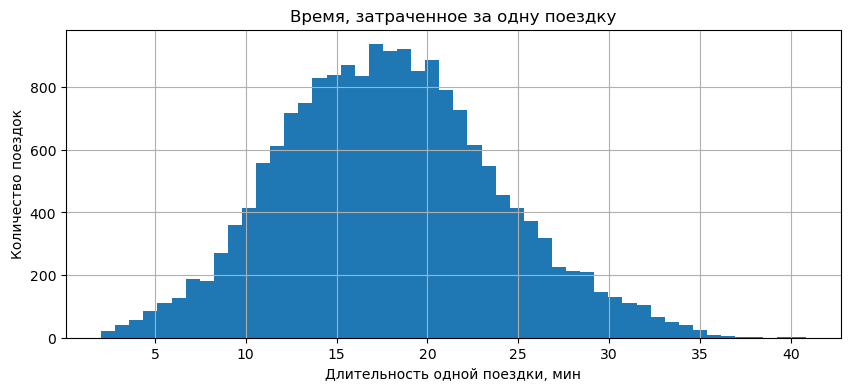

In [27]:
rides = rides.loc[rides['duration'] != 0.5]
rides['duration'].hist(bins=50, grid=True, figsize=(10,4))
plt.title('Время, затраченное за одну поездку')
plt.xlabel('Длительность одной поездки, мин')
plt.ylabel('Количество поездок')

**Вывод**

Описана и визуализирована общая информация о пользователях и поездках.

**Частота встречаемости городов**
- Представлено 8 городов, почти равномерно распределенных по числу пользователей (от 170 до 220 пользователей в каждом городе).

**Распределение по подпискам**
- Пользователей, имеющих платную подписку, немного больше (835 человек против 699 человек без подписки).

**Возраст пользователей**
- Возраст большинства пользователей приходится на 20 - 30 лет.

**Расстояние, которое пользователь преодолел за одну поездку**
- Длина одной поездки составляет в основном 2543-3777 м (медианное значение - 3133 м). Все, что более 5600 м, можно отнести к выбросам, то есть к необычно длинным дистанциям. И наоборот, необычно короткие дистанции - те, что меньше 693 м.
- В распределении имеется второе пиковое значение около 700 м. Это может быть связано с тем, что пользователь прервал свою поездку по причине неисправности самоката или по личным причинам. 

**Продолжительность поездок**
- Длительность одной поездки представляет собой нормальное распределение и составляет в основном 13-21 мин. Все, что более 34 мин, можно отнести к выбросам, то есть к необычно долгим поездкам.
- Выявлены и удалены аномальные значения продолжительности поездки в 95 строках. 

#### Шаг 4. Объединение данных

In [28]:
# Объединяем три таблицы в одну общую
data_total = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
display(data_total)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [29]:
# Сравниваем полученное количество строк с исходными таблицами
print(users.shape)
print(rides.shape)
print(subscriptions.shape)

(1534, 5)
(17973, 5)
(2, 4)


Количество строк полученной таблицы соответствуют количеству строк самой длинной таблицы **rides**.

In [30]:
# Данные о пользователях без подписки
data_free = data_total.query('subscription_type == "free"')
display(data_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [31]:
# Данные о пользователях с подпиской
data_ultra = data_total.query('subscription_type == "ultra"')
display(data_ultra)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [32]:
# Характеристики расстояния у пользователей без подписки
print(data_free['distance'].describe())

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64


In [33]:
# Характеристики расстояния у пользователей с подпиской
print(data_ultra['distance'].describe())

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


Text(0, 0.5, 'Количество поездок')

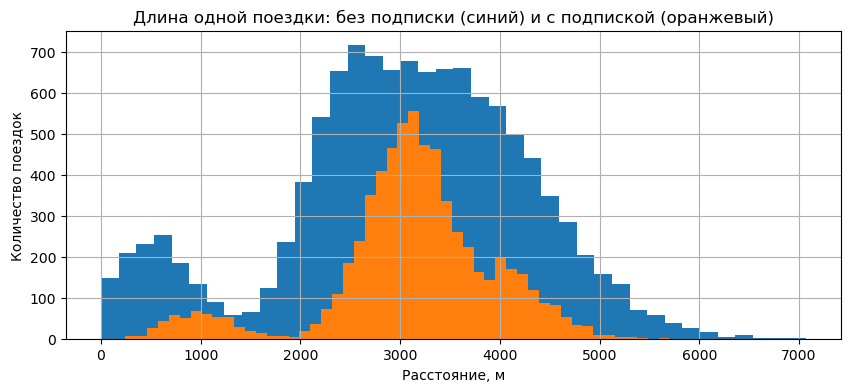

In [34]:
# Длина одной поездки у пользователей без подписки
data_free['distance'].hist(bins=40, grid=True, figsize=(10,4))

# Длина одной поездки у пользователей с подпиской
data_ultra['distance'].hist(bins=50, grid=True, figsize=(10,4))
plt.title('Длина одной поездки: без подписки (синий) и с подпиской (оранжевый)')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

In [35]:
# Характеристики расстояния у пользователей без подписки
print(data_free['duration'].describe())

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64


In [36]:
# Характеристики расстояния у пользователей с подпиской
print(data_ultra['duration'].describe())

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


Text(0, 0.5, 'Количество поездок')

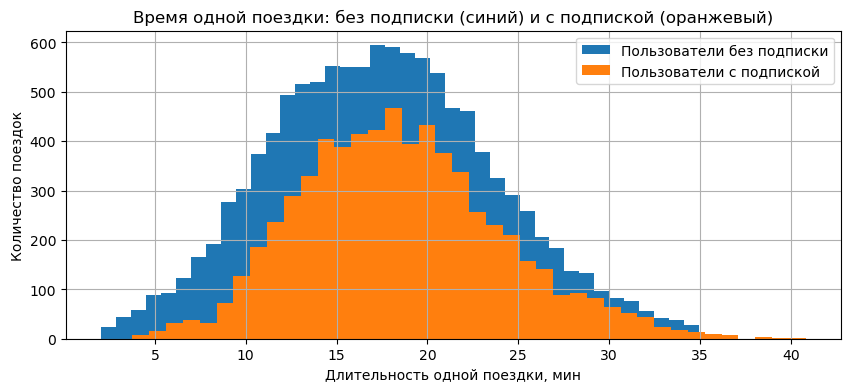

In [37]:
# Длительность одной поездки у пользователей без подписки
data_free['duration'].hist(bins=40, grid=True, figsize=(10,4), label='Пользователи без подписки')
# Длительность одной поездки у пользователей с подпиской
data_ultra['duration'].hist(bins=40, grid=True, figsize=(10,4), label='Пользователи с подпиской')

plt.legend()

plt.title('Время одной поездки: без подписки (синий) и с подпиской (оранжевый)')
plt.xlabel('Длительность одной поездки, мин')
plt.ylabel('Количество поездок')

**Вывод**

Объединены данные о пользователях, поездках и подписках в одну таблицу **data_total**.
Создано две таблицы c данными о пользователях без подписки **data_free** и с данными о пользователях с подпиской **data_ultra**.

Пользователи без подписки **data_free**:
- Длина одной поездки составляет в основном 2300 - 3900 м. Длительность одной поездки - 13-21 мин.

Пользователи с подпиской **data_ultra**:
- Длина одной поездки составляет в основном 2700 - 3600 м. Длительность одной поездки - 14-21 мин.

При очень близком медианном значении длины поездки у пользователей с подпиской и без, можно выделить более широкий разброс в расстоянии, которое чаще проезжают пользователи без подписки.

Медианное значение длительности одной поездки у пользователей с подпиской немного выше (18 мин), чем у пользователей без подписки (17 мин).

#### Шаг 5. Подсчёт выручки

In [38]:
# Предварительно округляем продолжительность поездки до следующего целого числа
data_total['duration'] = np.ceil(data_total['duration']) 

# Группируем таблицу по пользователям и месяцам
data_total_grouped = data_total.groupby(['user_id', 'month'])\
      .agg({'distance':'sum', 'duration':['sum', 'count'], 'subscription_type':'first', 'start_ride_price': 'first',\
      'minute_price': 'first', 'subscription_fee': 'first'})

# Корректируем названия столбцов
data_total_grouped.columns = ['distance_sum', 'duration_sum', 'rides_count',  'subscription_type', 'start_ride_price',\
                              'minute_price', 'subscription_fee']
display(data_total_grouped.head(10))

distance_sum  duration_sum  rides_count subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
        12      6751.629942          28.0            2             ultra   
2       3      10187.723006          63.0            3             ultra   
        4       6164.381824          40.0            2             ultra   
        6       3255.338202          14.0            1             ultra   
        7       6780.722964          48.0            2             ultra   

               start_ride_price  minute_price  subscription_fee  
user_id month                                                    
1       1                     0             6               199  
        4                     0             6               199  
        8                     0             6               199  
        10                    0             6               199  
        11                    0             6               199  
        12                    0             6               199  
2       3                     0             6               199  
        4                     0             6               199  
        6                     0             6               199  
        7                     0             6               199

In [39]:
# Добавляем столбец с помесячной выручкой
data_total_grouped['revenue_month'] = data_total_grouped['start_ride_price'] * data_total_grouped['rides_count']\
+ data_total_grouped['minute_price'] * data_total_grouped['duration_sum'] + data_total_grouped['subscription_fee']
display(data_total_grouped.head(10))

distance_sum  duration_sum  rides_count subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
        12      6751.629942          28.0            2             ultra   
2       3      10187.723006          63.0            3             ultra   
        4       6164.381824          40.0            2             ultra   
        6       3255.338202          14.0            1             ultra   
        7       6780.722964          48.0            2             ultra   

               start_ride_price  minute_price  subscription_fee  revenue_month  
user_id month                                                                   
1       1                     0             6               199          451.0  
        4                     0             6               199          241.0  
        8                     0             6               199          475.0  
        10                    0             6               199          391.0  
        11                    0             6               199          535.0  
        12                    0             6               199          367.0  
2       3                     0             6               199          577.0  
        4                     0             6               199          439.0  
        6                     0             6               199          283.0  
        7                     0             6               199          487.0

**Вывод**

Создана новая таблица, сгруппированная по пользователям и месяцам. Добавлен столбец `revenue_month` с помесячной выручкой по каждому пользователю.

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

**Нулевая гипотеза:**
- H0 - пользователи с подпиской и без тратят на поездки одинаковое время. 

**Альтернативная правосторонняя гипотеза:**
- Н1 - пользователи с подпиской тратят больше времени на поездки.

In [40]:
ultra_duration = data_ultra['duration']
free_duration = data_free['duration']
alpha = 0.05
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
print ('P-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем Н0')
else:
    print('Не отвергаем Н0')

P-value: 4.704468074453899e-28
Отвергаем Н0


In [41]:
# Средняя продолжительность поездок для пользователей с подпиской и без подписки
print(ultra_duration.mean())
print(free_duration.mean())

18.54198516280583
17.530771268800226


**Вывод**: отвергаем гипотезу о том, что пользователи с подпиской и без тратят на поездки одинаковое время, так как полученное значение p-value гораздо ниже заданного уровня значимости. Есть все основания говорить, что пользователи с подпиской тратят больше времени на поездки. Дополнительно подтверждаем, что средняя продолжительность поездки у пользователей с подпиской выше, чем у пользователей без подписки.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза:**
- H0 - помесячная выручка от пользователей с подпиской и без одинакова.

**Альтернативная правосторонняя гипотеза:**
- Н1 - помесячная выручка от пользователей с подпиской выше, чем у пользователей без подписки.

In [42]:
ultra_revenue = data_total_grouped[data_total_grouped['subscription_type'] == 'ultra']['revenue_month']
free_revenue = data_total_grouped[data_total_grouped['subscription_type'] == 'free']['revenue_month']
alpha = 0.05
results = st.ttest_ind(ultra_revenue, free_revenue, alternative='greater')
print ('P-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем Н0')
else:
    print('Не отвергаем Н0')

P-value: 2.0314113674863288e-30
Отвергаем Н0


In [43]:
# Среднее значение выручки от пользователей с подпиской и без подписки
print(ultra_revenue.mean())
print(free_revenue.mean())

362.7921906022502
329.3326437121324


**Вывод**: отвергаем гипотезу о том, что помесячная выручка от пользователей с подпиской и без одинакова, так как полученное значение p-value гораздо ниже заданного уровня значимости. Есть все основания говорить, что помесячная выручка от пользователей с подпиской выше, чем у пользователей без подписки. Дополнительно подтверждаем, что среднее значение выручки от пользователей с подпиской выше, чем у пользователей без подписки.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данной ситуации рассматривается гипотеза о равенстве средних для зависимых (парных) выборок. Используем метод **scipy.stats.ttest_rel()**.

**H0: мю1 = мю2**

**Н1: мю1 > мю2**

Здесь мю1 - среднее значение количества обращений до обновления, мю2 - после. Проверяем правостороннюю гипотезу: alternative='greater'.

#### Шаг 7. Общие выводы

Проанализированы данные и проверены некоторые гипотезы, которые могут помочь вырасти бизнесу по аренде самокатов. 

**Предварительно была выполнена предобработка данных:**

- Приведена к типу даты дата поездки.

- Удалены явные дубликаты.

- Добавлен столбец `month` с месяцем поездки.


**Описана и визуализирована общая информация о пользователях и поездках:**

- Представлено 8 городов, почти равномерно распределенных по числу пользователей (от 170 до 220 пользователей в каждом городе).

- Пользователей, имеющих платную подписку, немного больше (835 человек против 699 человек без подписки).

- Возраст большинства пользователей приходится на 20 - 30 лет.

- Длина одной поездки составляет в основном 2543-3777 м (медианное значение - 3133 м). Все, что более 5600 м, можно отнести к выбросам, то есть к необычно длинным дистанциям. И наоборот, необычно короткие дистанции - те, что меньше 693 м.
    - Длина одной поездки у пользователей без подписки имеет более широкий разброс часто встречаемых значений (2300 - 3900 м), у пользователей с подпиской - более узкий колокол у распределения (2700 - 3600 м).

- Длительность одной поездки представляет собой нормальное распределение и составляет в основном 13-21 мин. Все, что более 34 мин, можно отнести к выбросам, то есть к необычно долгим поездкам.
    - Медианное значение длительности одной поездки у пользователей с подпиской немного выше (18 мин), чем у пользователей без подписки (17 мин).

**Проверены гипотезы:**

- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- Не можем утверждать, что пользователи с подпиской проезжают менее 3130 метров.
- Помесячная выручка от пользователей с подпиской выше, чем у пользователей без подписки.

**Рекомендации:**

- Наибольший интерес для бизнеса представляют пользователи с подпиской. Они приносят бОльшую выручку. При этом доля пользователей с подпиской менее 50%. Есть смысл направить ресурсы на повышение спроса на оформление подписки.
- Несмотря на то, что в Москве большой спрос на аренду самокатов, именно там меньше всего пользователей сервисом GoFast. Вероятно, это связано с высокой конкуренцией, и есть смысл рассмотреть и другие крупные города, где еще рынок аренды самокатов не сильно развит.
- В связи с тем, что большинство пользователей самокатов - молодежь (20 - 30 лет), можно рекомендовать уделять особое внимание наличию самокатов вблизи учебных заведений.
